In [4]:
# install necessary packages

using Pkg
#Pkg.add(["Distributions","HDF5","Statistics","DataFrames","CSV","DataStructures","UpdateJulia","StatsBase","Shuffle","PyPlot"])
#Pkg.update()
#Pkg.build("PyCall")

using Statistics
using HDF5
using DataFrames
using Distributions
using DataStructures
using StatsBase
using CSV
using Shuffle
using Profile
using PyPlot

# check number of threads for parallelization
Threads.nthreads()

4

In [2]:
# load latest algorithms
include("smooth_algs.jl")

cleanBases (generic function with 1 method)

In [ ]:
# make environments

T = 100 # horizon
policies= [RAND, BE, METAone] # list of policies
saveRes = "off" # save results
saveProb = "off" # save prob
loadProb = "off" # load saved problem
series="trignewreal"  # name of series
lP = length(policies) # number of policies

# sub-sample the time
tsave=floor.(Int,collect(range(1,T,length=500)))'
ts = length(tsave)

N=5 # number of trials
P=[] # problems
amps = zeros(N)
coefs = zeros(N)
if (loadProb != "on")
    # make trigonometric gap function for gap Delta(1,2)
    trig = -amplitude*sin.(frequency*pi*collect(0:(1/T):1) .+ phaseshift)
    trig = deleteat!(trig,(T+1))
    phaseshift = rand(Uniform(0, 2*pi))  # phi~U([0,2*pi])
    frequency = rand(Uniform(5, 10))  # f~U([5,10]) (really 2 times U([2.5,5]))
    amplitude = frequency^(-2)
    for i=1:N
        push!(P,trig)
        amps[i] = amplitude
        coefs[i] = pi^2 # 2nd order Holder coefficient
    end
end


for imeth in 1:lP
	policy = policies[imeth]
	# save regret and restarts
	Regret = zeros(N,ts)
	Restarts = zeros(N)
    repTimes = zeros(N)
    if (saveRes == "on")
        run(`rm -rf results/$(series)_$(policy)_T_$(T)_N_$(N)`)
        run(`mkdir results/$(series)_$(policy)_T_$(T)_N_$(N)`)
    end
    # save problem instance
    if (saveRes == "on")&&(loadProb != "on")&&(saveProb == "on")
        problemName = "problem/$(series)"
        run(`rm -rf problem/$(series)`)
        h5write(problemName,"phaseshift",phaseshift)
        h5write(problemName,"frequency",frequency)
        h5write(problemName,"amplitude",amplitude)           
    elseif (loadProb == "on") # or load problem from file
        problemName = "problem/$(series)"
        phaseshift = h5read(problemName,"phaseshift")
        frequency = h5read(problemName,"frequency")
        amplitude = frequency^(-2)
        trig = -amplitude*sin.(frequency*pi*collect(0:(1/T):1) .+ phaseshift)
        trig = deleteat!(trig,(T+1))
    end
	Threads.@threads for n in 1:N
        ChangePoints=[]
        ReceivedRewards=[]
        starttime = time()
        repTime=0
		if policy==RANDone
            ChosenArms, ReceivedRewards = RANDone(P[n])
            ChangePoints=[]
		elseif policy==METAone
            ChosenArms,ChangePoints,ReceivedRewards,repTime =  METAone(P[n],amps[n],[amps[n]*1,0.5,1],"off")  
        elseif policy==BE
            B2 = floor(Int,(coefs[n])^(-1/5)*(T^(2/5))*log(T)^(3/5))  # rate-optimal budget of ALG2
            Delta2 = floor(Int,(coefs[n])^(-2/5)*(T^(4/5))*log(T)^(1/5))  # rate-optimal epoch size of ALG2
            ChosenArms,ChangePoints = BE(T, [B2,Delta2], trig)     
        end
        opt_rew = max.(trig,0)
        reg = opt_rew - trig .* (ChosenArms .- 1)
        reg = cumsum(reg)
		Regret[n,:]=vec(reg[tsave])
		Restarts[n]=length(ChangePoints)
        repTimes[n] = repTime
        name = "results/$(series)_$(policy)_T_$(T)_N_$(N)/$(n)"
        elapsed = time() - starttime
    	print("$(n): elapsed time is $(elapsed)\n")
        if (saveRes == "on")
           	h5write(name,"Regret",Regret[n,:])
    		h5write(name,"Restarts",Restarts[n])
            h5write(name,"Time",elapsed)
            h5write(name,"ReplayTime",repTime)
    	end
	end
	print("Results for $(policy)\n")
	print("Mean final regret is $(mean(Regret[:,end])) with std $(std(Regret[:,end]))\n")
	print("Mean number of restarts is $(mean(Restarts)) with std $(std(Restarts))\n")
    print("percent of replay rounds: $(mean(repTimes)/T)\n")
end

Mean final regret for RANDone is 46869.02558168701 with  15.81807580350733)
Mean number of restarts is 0.0 with std 0.0
Mean replay time fraction is 0.0
Mean final regret for BE is 46273.18059281066 with  3.66401612951767)
Mean number of restarts is 0.0 with std 0.0
Mean replay time fraction is 0.0
Mean final regret for METAone is 10604.896408028122 with  2531.654140473541)
Mean number of restarts is 8.0 with std 0.0
Mean replay time fraction is 0.129839964


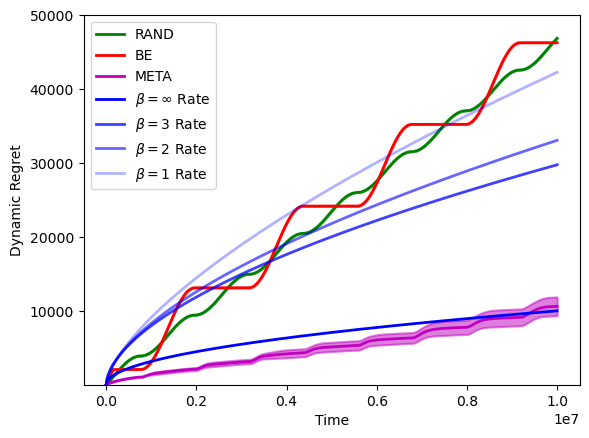

In [6]:
# plot regret curves from saved results

# parameters from above
T = 10^7 # horizon
N=100 # number of trials
series="trignew" # name of series

# list of policies
policies= [RANDone,BE,METAone]
names = ["RAND","BE","META"] # names to appear on labels
lP = length(policies)

df=DataFrame(Algo= String[],Regret=Float32[],Stdev=Float32[])
clf()
figure()
colors=["g","r","m"]
tsave=floor.(Int,collect(range(1,T,length=500)))
problemName = "problem/$(series)"
phaseshift = h5read(problemName,"phaseshift")
frequency = h5read(problemName,"frequency")
amplitude = h5read(problemName,"amplitude")

# display results and plot the regret
for imeth in 1:lP
    policy = policies[imeth]
    thisname = names[imeth]
    Restarts = zeros(Int,N)
    Regret=zeros(N,length(tsave))
    repTimes = zeros(N)
    inds=[]
    for m in 1:N
        name = "results/$(series)_$(policy)_T_$(T)_N_$(N)/$(m)"
        if isfile(name)
            Regret[m,:]=h5read(name,"Regret")
            Restarts[m] = h5read(name,"Restarts")
            repTimes[m] = h5read(name,"ReplayTime")
            push!(inds,m)
        end
    end
    Regret = Regret[inds,:]
    Restarts = Restarts[inds]
    repTimes = repTimes[inds]
    # print stuff
    regfinal = mean(Regret[:,end])
    stdevfinal = std(Regret[:,end])
    push!(df,("$(policy)",regfinal,stdevfinal))
    print("Mean final regret for $(policy) is $(regfinal) with  $(stdevfinal))\n")
    print("Mean number of restarts is $(mean(Restarts)) with std $(std(Restarts))\n")
    print("Mean replay time fraction is $(mean(repTimes)/T)\n")
	# plot regret
    PyPlot.ylim(top=50000)
    PyPlot.ylim(bottom=1)
    PyPlot.yscale("linear")
    PyPlot.plot(vec(tsave),vec(mean(Regret,dims=1)),linewidth=2,label="$(names[imeth])",color=colors[imeth])
    PyPlot.fill_between(vec(tsave),max(zeros(length(tsave)), vec(mean(Regret,dims=1).-0.5*std(Regret,dims=1))),
            vec(mean(Regret,dims=1).+0.5*std(Regret,dims=1)),
            alpha=.5,
            interpolate=true,
            color=colors[imeth],
            linewidth=1.5)
end
coeff2 = amplitude*(pi*frequency)
coeff1 = amplitude
coeff3 = amplitude*(pi*frequency)^2
coeff4 = amplitude*(pi*frequency)^3
PyPlot.plot(vec(tsave),vec(sqrt.(10 .* tsave)),linewidth=2,label=latexstring("\$\\beta=\\infty\$ Rate"),color="b",alpha=1)
PyPlot.plot(vec(tsave),vec(coeff4^(1/7) .* (tsave) .^ (4/7) .* 2^(3/7) ),linewidth=2,label=latexstring("\$\\beta=3\$ Rate"),color="b",alpha=0.75)
PyPlot.plot(vec(tsave),vec(coeff3^(1/5) .* (tsave) .^ (3/5) .* 2^(2/5)),linewidth=2,label=latexstring("\$\\beta=2\$ Rate"),color="b",alpha=0.6)
PyPlot.plot(vec(tsave),vec(coeff2^(1/3) .* (tsave) .^ (2/3) .* 2^(1/3)),linewidth=2,label=latexstring("\$\\beta=1\$ Rate"),color="b",alpha=0.3)
legend(loc="upper left")
xlabel("Time")
ylabel("Dynamic Regret")
savefig("plot.png")



amplitude: 0.01444588223139156
frequency: 8.320088866618766
phase shift: 1.1478977247810018


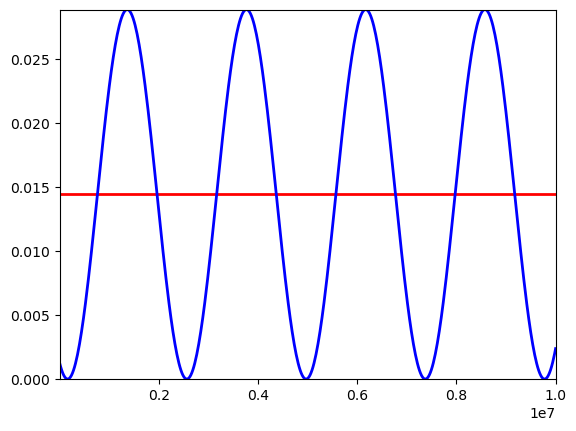

In [8]:
# plot environment rewards over time

# parameters from above
T = 10^7 # horizoin
N=100 # number of trials
series="trignew" # name of experiment series

clf()
clf()
figure()
tsave=floor.(Int,collect(range(1,T,length=500)))
problemName = "problem/$(series)"
phaseshift = h5read(problemName,"phaseshift")
frequency = h5read(problemName,"frequency")
amplitude = h5read(problemName,"amplitude")

PyPlot.ylim(top=2*amplitude)
PyPlot.ylim(bottom=0)
PyPlot.xlim((1,T))
PyPlot.yscale("linear")
PyPlot.hlines(amplitude, minimum(1), maximum(T), colors="red", linewidth=2)
rew = amplitude .- amplitude*sin.(frequency*pi*collect(0:(1/T):1) .+ phaseshift)
rew = deleteat!(rew,(T+1))
PyPlot.plot(vec(tsave),vec(rew[tsave]),linewidth=2,color="b")
savefig("rewards.png")
println("amplitude: $(amplitude)")
println("frequency: $(frequency)")
println("phase shift: $(phaseshift)")
